<a href="https://colab.research.google.com/github/Luana-lrb/LIPAI_Python/blob/main/onboarding/src/semana_10/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning**

### Como base foi utilizado o trabalho dos Profs. Storopoli & Souza disponível no Google Colab:
https://colab.research.google.com/github/storopoli/ciencia-de-dados/blob/main/notebooks/Aula_19_Redes_Neurais_Convolucionais_com_PyTorch.ipynb#scrollTo=oR24U2WYKVrw


Importando bibliotecas necessárias:

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader,random_split
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import time

Device: usa GPU se disponível

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Treinando em:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Treinando em: cuda
GPU: Tesla T4


**Transformações para Resnet**

In [3]:
trans_ResNet_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # ResNet espera 3 canais
    transforms.Resize((224, 224)),  # ResNet espera imagens 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalização ImageNet
])

trans_ResNet_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Transformações para o modelo ConvNet

In [4]:
trans_convnet_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trans_convnet_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

O modelo Original

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(7 * 7 * 64, 1000),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

Criando função de treinamento para os modelos, a fim de fazer a comparação

In [6]:
def train_model(model_name, model, trans_train, trans_test):
    print(f"Treinando o modelo: {model_name}")

    # carregando os dados
    root_path = '/home/storopoli/Downloads'
    train_dataset_full = torchvision.datasets.MNIST(
        root=root_path, train=True, transform=trans_train, download=True
    )
    test_dataset = torchvision.datasets.MNIST(
        root=root_path, train=False, transform=trans_test
    )

    train_size = int(0.8 * len(train_dataset_full))
    val_size = len(train_dataset_full) - train_size
    train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

    batch_size = 32
    num_workers = 0
    pin_memory = True if device.type == "cuda" else False

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=pin_memory)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             num_workers=num_workers, pin_memory=pin_memory)
    # criando o modelo
    model = model.to(device)
    parametros = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Parâmetros treináveis: {parametros}")

    # hiperparâmetros
    loss_fn = nn.CrossEntropyLoss()
    learning_rate = 0.001
    epochs = 6
    optimizer = Adam(model.parameters(), lr=learning_rate)

    torch.backends.cudnn.benchmark = True if device.type == "cuda" else False

    # listas para histórico
    train_losses = []
    train_accuracies = []
    f1_macro_scores = []
    f1_weighted_scores = []
    f1_per_class_scores = []
    val_losses = []
    val_accuracies = []

    best_val_acc = 0.0
    start_time = time.time()

    # ========== LOOP DE TREINAMENTO ==========
    for epoch in range(epochs):
        model.train()
        running_loss, running_correct, running_total = 0.0, 0, 0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # forward + loss
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # backward + update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # métricas do step
            total = labels.size(0)
            predicted = outputs.argmax(dim=1)
            correct = (predicted == labels).sum().item()
            acc = 100 * correct / total

            running_loss += loss.item()
            running_correct += correct
            running_total += total

        # calcular métricas
        train_epoch_loss = running_loss / len(train_loader)
        train_epoch_acc = 100 * running_correct / running_total

        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_acc)

        # validação
        model.eval()
        all_predictions = []
        all_labels = []
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                outputs = model(images)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item()
                predicted = outputs.argmax(dim=1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total
        f1_macro = f1_score(all_labels, all_predictions, average='macro')
        f1_weighted = f1_score(all_labels, all_predictions, average='weighted')
        f1_per_class = f1_score(all_labels, all_predictions, average=None)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        f1_macro_scores.append(f1_macro)
        f1_weighted_scores.append(f1_weighted)
        f1_per_class_scores.append(f1_per_class)

        if val_acc > best_val_acc:
            best_val_acc = val_acc

        print(f"Época [{epoch+1}/{epochs}] - "
              f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {f1_macro*100:.2f}%")

    # teste final
    model.eval()
    test_correct = 0
    test_total = 0
    test_preds = []
    test_labels_list = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)
            predicted = outputs.argmax(dim=1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            test_preds.extend(predicted.cpu().numpy())
            test_labels_list.extend(labels.cpu().numpy())


    test_accuracy = 100 * test_correct / test_total
    test_f1_macro = f1_score(test_labels_list, test_preds, average='macro')
    test_f1_weighted = f1_score(test_labels_list, test_preds, average='weighted')
    test_f1_per_class = f1_score(test_labels_list, test_preds, average=None)
    training_time = time.time() - start_time

    print(f"Resultados da modelo - {model_name}")
    print(f"Acurácia no Teste: {test_accuracy:.3f}%")
    print(f"F1 no Teste: {test_f1_macro*100:.2f}%")
    print(f"Melhor Acurácia na Validação: {best_val_acc:.2f}%")
    print(f"Tempo de Treinamento: {training_time:.2f}s")

    return {
    'name': model_name,
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'val_f1_scores': f1_macro_scores,
    'test_accuracy': test_accuracy,
    'test_f1_macro': test_f1_macro,
    'test_f1_weighted': test_f1_weighted,
    'test_f1_per_class': test_f1_per_class,
    'best_val_acc': best_val_acc,
    'training_time': training_time,
    'num_params': parametros
}



Criando o ResNet18 From Scratch

In [7]:
def create_resnet18_mnist():
    model = models.resnet18(weights=None)  # weights=None para treinar do zero

    # a primeira camada já aceita 3 canais por padrão
    # model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # modificar a última camada para 10 classes (MNIST tem 10 dígitos)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 10)

    return model

Executando experimentos

In [8]:
resultados = []

In [9]:
convnet_model = ConvNet()
resultados.append(train_model("ConvNet (Original)", convnet_model,
                          trans_convnet_train, trans_convnet_test))

Treinando o modelo: ConvNet (Original)


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 447kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.22MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.26MB/s]


Parâmetros treináveis: 3199106
Época [1/6] - Train Loss: 0.1129, Train Acc: 96.47% | Val Loss: 0.0840, Val Acc: 97.42%, Val F1: 97.43%
Época [2/6] - Train Loss: 0.0409, Train Acc: 98.77% | Val Loss: 0.0602, Val Acc: 98.42%, Val F1: 98.41%
Época [3/6] - Train Loss: 0.0295, Train Acc: 99.10% | Val Loss: 0.0458, Val Acc: 98.92%, Val F1: 98.92%
Época [4/6] - Train Loss: 0.0232, Train Acc: 99.28% | Val Loss: 0.0424, Val Acc: 98.78%, Val F1: 98.77%
Época [5/6] - Train Loss: 0.0181, Train Acc: 99.44% | Val Loss: 0.0660, Val Acc: 98.60%, Val F1: 98.59%
Época [6/6] - Train Loss: 0.0152, Train Acc: 99.53% | Val Loss: 0.0735, Val Acc: 98.50%, Val F1: 98.48%
Resultados da modelo - ConvNet (Original)
Acurácia no Teste: 98.560%
F1 no Teste: 98.55%
Melhor Acurácia na Validação: 98.92%
Tempo de Treinamento: 114.19s


In [10]:
resnet18_model = create_resnet18_mnist()
resultados.append(train_model("ResNet18 (From Scratch)", resnet18_model,
                          trans_ResNet_train, trans_ResNet_test))

Treinando o modelo: ResNet18 (From Scratch)
Parâmetros treináveis: 11181642
Época [1/6] - Train Loss: 0.1204, Train Acc: 96.28% | Val Loss: 0.0736, Val Acc: 97.60%, Val F1: 97.60%
Época [2/6] - Train Loss: 0.0511, Train Acc: 98.40% | Val Loss: 0.0666, Val Acc: 98.09%, Val F1: 98.10%
Época [3/6] - Train Loss: 0.0392, Train Acc: 98.79% | Val Loss: 0.0337, Val Acc: 98.97%, Val F1: 98.96%
Época [4/6] - Train Loss: 0.0334, Train Acc: 98.94% | Val Loss: 0.0271, Val Acc: 99.27%, Val F1: 99.26%
Época [5/6] - Train Loss: 0.0262, Train Acc: 99.13% | Val Loss: 0.0357, Val Acc: 98.88%, Val F1: 98.87%
Época [6/6] - Train Loss: 0.0240, Train Acc: 99.24% | Val Loss: 0.0568, Val Acc: 98.13%, Val F1: 98.10%
Resultados da modelo - ResNet18 (From Scratch)
Acurácia no Teste: 98.260%
F1 no Teste: 98.21%
Melhor Acurácia na Validação: 99.27%
Tempo de Treinamento: 1473.62s


Gráfico com Loss e Validação:

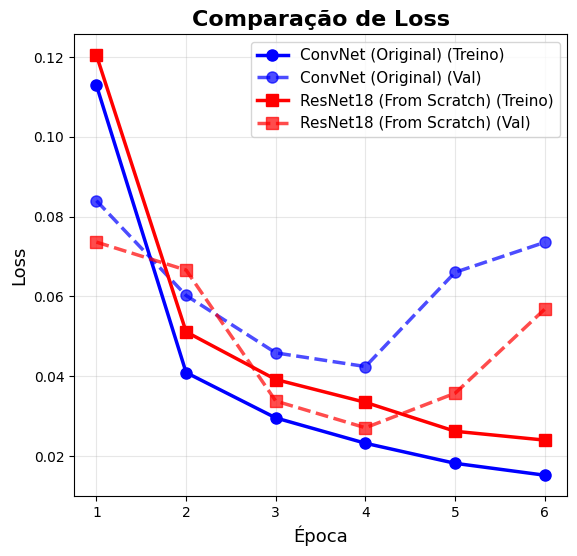

In [11]:
colors = ['blue', 'red']
markers = ['o', 's']

# Gráfico 1: Loss de Treinamento e Validação
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i, result in enumerate(resultados):
    num_epochs = len(result['train_losses'])
    epochs_range = range(1, num_epochs + 1)

    plt.plot(epochs_range, result['train_losses'],
             color=colors[i], marker=markers[i], linestyle='-',
             label=f"{result['name']} (Treino)", linewidth=2.5, markersize=8)
    plt.plot(epochs_range, result['val_losses'],
             color=colors[i], marker=markers[i], linestyle='--',
             label=f"{result['name']} (Val)", linewidth=2.5, markersize=8, alpha=0.7)

plt.title('Comparação de Loss', fontsize=16, fontweight='bold')
plt.xlabel('Época', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

Acurácia de Treinamento e Validação:

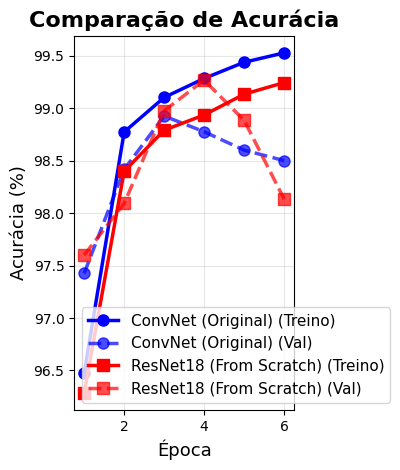

In [12]:
plt.subplot(1, 2, 2)
for i, result in enumerate(resultados):
    num_epochs = len(result['train_accuracies'])
    epochs_range = range(1, num_epochs + 1)

    plt.plot(epochs_range, result['train_accuracies'],
             color=colors[i], marker=markers[i], linestyle='-',
             label=f"{result['name']} (Treino)", linewidth=2.5, markersize=8)
    plt.plot(epochs_range, result['val_accuracies'],
             color=colors[i], marker=markers[i], linestyle='--',
             label=f"{result['name']} (Val)", linewidth=2.5, markersize=8, alpha=0.7)

plt.title('Comparação de Acurácia', fontsize=16, fontweight='bold')
plt.xlabel('Época', fontsize=13)
plt.ylabel('Acurácia (%)', fontsize=13)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resnet_vs_convnet_curves.png', dpi=300, bbox_inches='tight')
plt.show()

Gráfico comparativo:

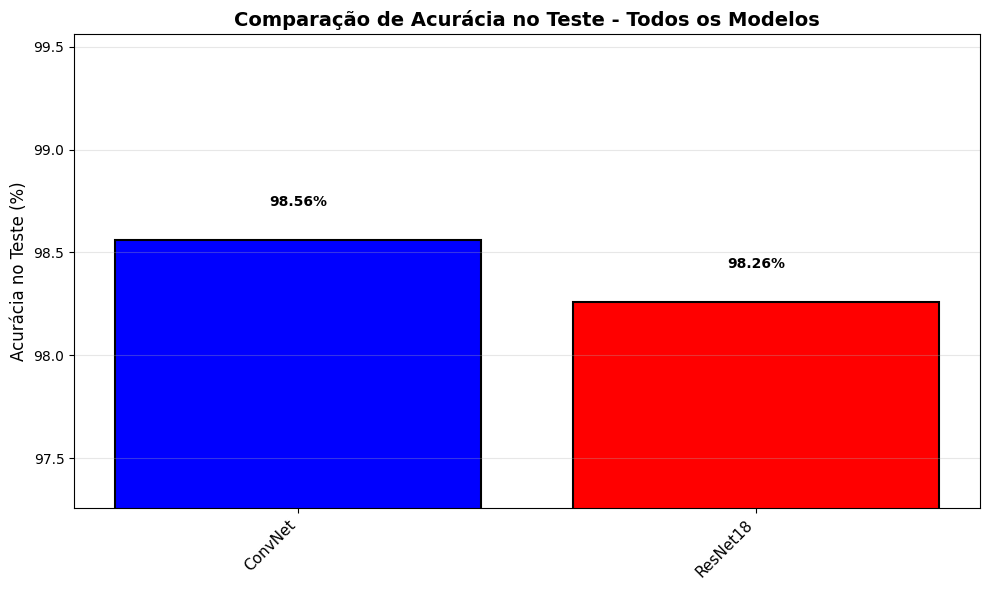

In [13]:
plt.figure(figsize=(10, 6))

pipeline_names = [r['name'] for r in resultados]
test_accs = [r['test_accuracy'] for r in resultados]

bars = plt.bar(range(len(resultados)), test_accs, color=colors, edgecolor='black', linewidth=1.5)
plt.xticks(range(len(resultados)), [name.split('(')[0].strip() for name in pipeline_names],
           rotation=45, ha='right', fontsize=11)
plt.ylabel('Acurácia no Teste (%)', fontsize=12)
plt.title('Comparação de Acurácia no Teste - Todos os Modelos', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim([min(test_accs) - 1, max(test_accs) + 1])

# adicionar valores nas barras
for i, v in enumerate(test_accs):
    plt.text(i, v + 0.15, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

Agora para a análise do f1-score:

In [35]:
def plot_f1_comparison(resultados):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # F1-score ao longo das épocas
    ax = axes[0]
    for res in resultados:
        ax.plot(range(1, len(res['val_f1_scores'])+1),
               res['val_f1_scores'], marker='o',
               label=res['name'])
    ax.set_xlabel('Época')
    ax.set_ylabel('F1-Score Macro (%)')
    ax.set_title('F1-Score de Validação por Época')
    ax.legend()
    ax.grid(True)

    # F1-score final no teste
    ax = axes[1]
    names = []
    for res in resultados:
      names.append(res['name'].split('-')[1].strip() if '-' in res['name'] else res['name'])
    f1_macros = [res['test_f1_macro'] for res in resultados]
    f1_weighteds = [res['test_f1_weighted'] for res in resultados]

    x = np.arange(len(names))
    width = 0.35

    ax.bar(x - width/2, f1_macros, width, label='F1-Macro', color='#4ECDC4')
    ax.bar(x + width/2, f1_weighteds, width, label='F1-Weighted', color='#45B7D1')

    ax.set_ylabel('F1-Score (%)')
    ax.set_title('F1-Score no Teste')
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.legend()
    ax.set_ylim([min(min(f1_macros), min(f1_weighteds)), 1])

    for i, (v1, v2) in enumerate(zip(f1_macros, f1_weighteds)):
        ax.text(i - width/2, v1, f'{v1:.2f}%', ha='center', va='bottom', fontsize=9)
        ax.text(i + width/2, v2, f'{v2:.2f}%', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()


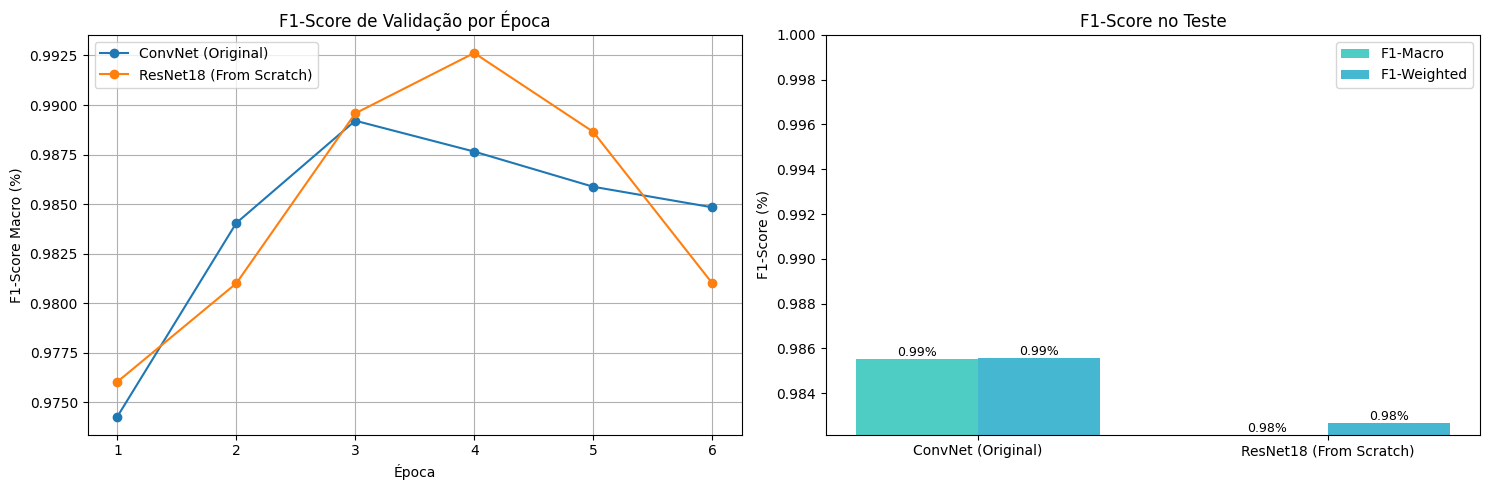

In [34]:
plot_f1_comparison(resultados)

In [24]:
def plot_f1_per_class(resultados):
    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(10)  # 10 classes (dígitos 0-9)
    width = 0.25

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    for idx, res in enumerate(resultados):
        offset = (idx - len(resultados)/2 + 0.5) * width
        ax.bar(x + offset, res['test_f1_per_class'], width,
              label=res['name'],
              color=colors[idx % len(colors)])

    ax.set_xlabel('Classe (Dígito)')
    ax.set_ylabel('F1-Score (%)')
    ax.set_title('F1-Score por Classe no Conjunto de Teste')
    ax.set_xticks(x)
    ax.set_xticklabels(range(10))
    ax.legend()
    ax.grid(True, axis='y', alpha=0.3)
    ax.set_ylim([0, 1.5])

    plt.tight_layout()
    plt.show()

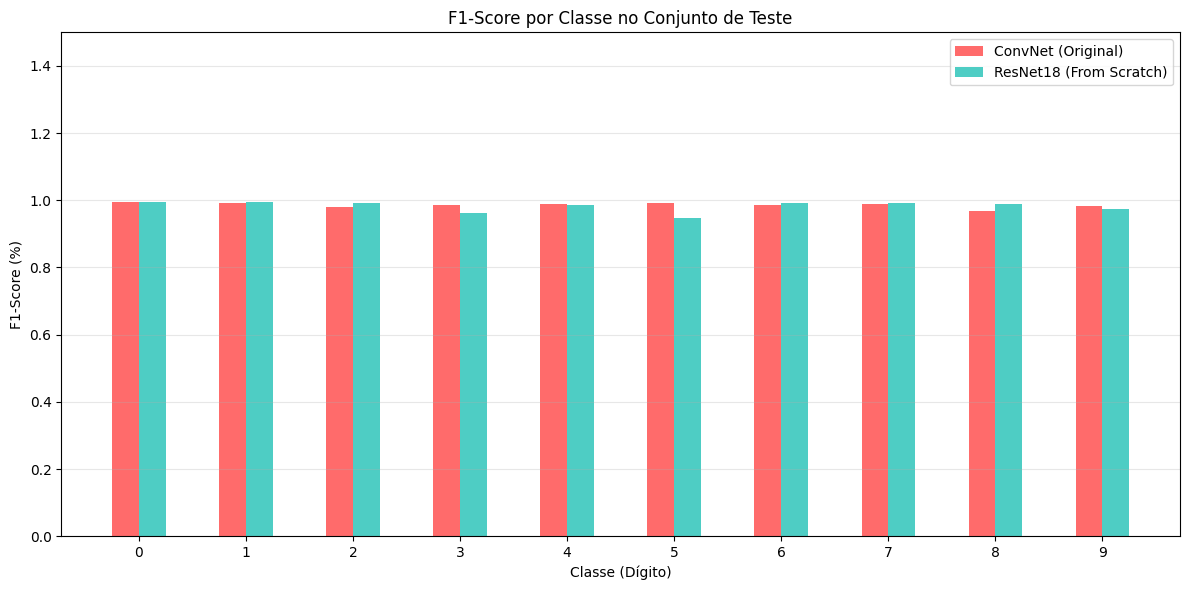

In [25]:
plot_f1_per_class(resultados)